In [278]:
import pandas as pd
import geopandas as gpd
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
from shapely import Point, wkt
import osmnx as ox
import contextily as ctx
import seaborn as sns
from hdbscan import HDBSCAN

# !pip install spatial-kfold
from spatialkfold.blocks import spatial_blocks 
from spatialkfold.clusters import spatial_kfold_clusters 
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneGroupOut, cross_validate, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor


random_seed = 100

london = ox.geocode_to_gdf('Greater London, UK')
london.to_crs(epsg=27700, inplace=True)
boros = gpd.read_file(os.path.join('data','shapefile','statistical-gis-boundaries-london','ESRI','London_Borough_Excluding_MHW.shp'))
boros.to_crs(epsg=27700, inplace=True)

# 1. Load data

In [279]:
df = pd.read_csv('data/cleaned/df_ml_new.csv',low_memory=True)
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:27700')
df.info()

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
# define target variable columns
targets = ['Total', 'Morning', 'Midday', 'Evening', 'Late']
targets_log = ['log_'+t for t in targets]

# Log transform the target variable
for col in targets:
    df['log_'+col] = df[col].apply(lambda x: 0 if x==0 else np.log(x))

In [ ]:
# define feature columns
features = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other',
            'diversity_poi','diversity_transp_mode','diversity_transp_opt',
            'cent_bus_degree','cent_bus_closeness','cent_bus_betweenness',
            'cent_rail_degree','cent_rail_closeness','cent_rail_betweenness'
            ]

features_main = ['population', 
            'poi_banking', 'poi_hotels','poi_leisure_active', 'poi_leisure_entertainment','poi_leisure_outdoor',
            'poi_medical', 'poi_nature', 'poi_public_facilities', 'poi_religious','poi_restaurants','poi_tourism','poi_shopping',
            'transport_bus','transport_rail','transport_other'
            ]

# lags as features
lags = ['lag_'+t for t in targets] #to pick one depending on the target

# 2. Evaluate model performance for each timeband

### 2.1 Set up spatial crossvalidation fold for training

In [ ]:
# Set up spatial cross-validation folds

df_point = df.copy()
df_point['geometry'] = [Point(x,y) for x,y in zip(df_point['x_coords'],df_point['y_coords'])]
df_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs='EPSG:27700')

# spatial kfold
df_clusters = spatial_kfold_clusters (gdf=df_point, name = 'id_code', nfolds = 5, algorithm='kmeans',
                                        random_state = random_seed, verbose = False) 

groups = df_clusters["folds"] # Cross-validation grouping setup
group_cvs =  LeaveOneGroupOut() # for spatial cross-validation when training the data
# group_kfold = GroupKFold(n_splits=10) # for spatial cross-validation when testing the data
groups.unique()

array([3, 5, 1, 4, 2])

### 2.2 Train the model on each time band

XGBoost

In [239]:
with open('data/modeltraining/best_xgb_1407.pkl', 'rb') as file:
    model = pickle.load(file)

In [280]:
# dictionary with 4 columns for Timeband, MAE, MSE, R2
results_xgb = pd.DataFrame()

# iterate for each tuned model above
for target in targets_log: # use log_ for target
    target_sel = target
    features_sel = features + ['x_coords', 'y_coords']

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # list to store the scores for each fold so that we can calculate the mean later
    mae_scores = []
    mse_scores = []
    r2_scores = []

    # iterate for each log_ target
    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores, add to the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    # Calculate the mean scores
    mean_mae = np.mean(mae_scores)
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    print(f"\n{target}:")
    print(f"Mean MAE: {mean_mae}")
    print(f"Mean MSE: {mean_mse}")
    print(f"Mean R^2: {mean_r2}")

    # add the mean scores to the dataframe
    ddf = pd.DataFrame({'Timeband': [target], 'MAE': [mean_mae], 'MSE': [mean_mse], 'R2': [mean_r2]})
    results_xgb = pd.concat([results_xgb, ddf], ignore_index=True,axis=0)

# save the results to a csv file
results_xgb.to_csv('output/modeltraining/r2_xgb_timeband_new_xy.csv', index=False)


log_Total:
Mean MAE: 0.6553557067997641
Mean MSE: 0.8872960250533607
Mean R^2: 0.7739039139265005

log_Morning:
Mean MAE: 0.6821412130627772
Mean MSE: 0.8900882548115678
Mean R^2: 0.7258737660059651

log_Midday:
Mean MAE: 0.6241365494224109
Mean MSE: 0.7956665826978668
Mean R^2: 0.7857656897194245

log_Evening:
Mean MAE: 0.7071322074530177
Mean MSE: 0.9356102596361733
Mean R^2: 0.7543424435699253

log_Late:
Mean MAE: 0.7750195061824551
Mean MSE: 0.9971026888829002
Mean R^2: 0.7216421428198807


In [ ]:
# dictionary with 4 columns for Timeband, MAE, MSE, R2
results_xgb = pd.DataFrame()

# iterate for each tuned model above
for target in targets_log: # use log_ for target
    target_sel = target
    features_sel = features + [lags[targets_log.index(target_sel)]] # use lag_ of target as feature

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # list to store the scores for each fold so that we can calculate the mean later
    mae_scores = []
    mse_scores = []
    r2_scores = []

    # iterate for each log_ target
    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores, add to the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    # Calculate the mean scores
    mean_mae = np.mean(mae_scores)
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    print(f"\n{target}:")
    print(f"Mean MAE: {mean_mae}")
    print(f"Mean MSE: {mean_mse}")
    print(f"Mean R^2: {mean_r2}")

    # add the mean scores to the dataframe
    ddf = pd.DataFrame({'Timeband': [target], 'MAE': [mean_mae], 'MSE': [mean_mse], 'R2': [mean_r2]})
    results_xgb = pd.concat([results_xgb, ddf], ignore_index=True,axis=0)

# save the results to a csv file
results_xgb.to_csv('output/modeltraining/r2_xgb_timeband_new.csv', index=False)


log_Total:
Mean MAE: 0.57031091431584
Mean MSE: 0.687043484654584
Mean R^2: 0.8225539706157046

log_Morning:
Mean MAE: 0.571176711542125
Mean MSE: 0.6140206311841192
Mean R^2: 0.8085496250972973

log_Midday:
Mean MAE: 0.5486025100506491
Mean MSE: 0.628994504049477
Mean R^2: 0.8284610275410094

log_Evening:
Mean MAE: 0.5930515720308772
Mean MSE: 0.6869475692080959
Mean R^2: 0.8185201159974891

log_Late:
Mean MAE: 0.6005604512129222
Mean MSE: 0.6348210694784437
Mean R^2: 0.8240012076241102


In [282]:
# fit the model with all the data and create columns for the predicted value

for target in targets_log:
    target_sel = target
    features_sel = features + [lags[targets_log.index(target_sel)]]

    X = df[features_sel]
    y = df[target_sel]

    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Fit the model
    model.fit(X, y)
    df['pred_'+target] = model.predict(X)

# save df
df.to_csv('data/cleaned/df_ml_new_pred.csv', index=False)

for target in targets_log:
    target_sel = target
    features_sel = features + ['x_coords', 'y_coords']

    X = df[features_sel]
    y = df[target_sel]

    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Fit the model
    model.fit(X, y)
    df['pred_'+target] = model.predict(X)

# save df
df.to_csv('data/cleaned/df_ml_new_pred_xy.csv', index=False)

# 3. Outlier detection

In [ ]:
# Load model
with open('data/modeltraining/best_xgb_1407.pkl', 'rb') as file:
    model = pickle.load(file)

In [283]:
# Function to simplify get outliers with residuals outside +/- 1.5*iqr
def get_outliers_xy(df, model, features, target):
    target_sel = 'log_'+target
    features_sel = features + ['x_coords', 'y_coords']

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, y)

    # Predict the water consumption on test set
    y_pred = model.predict(X_scaled)
    # Calculate the residuals
    residuals = y - y_pred
    
    df['residuals_'+target] = residuals # create new column
    df['is_outlier_'+target] = 0 # create new column

    # Identify buildings with residuals more than +/- 1.5*IQR
    q1 = residuals.quantile(0.25)
    q3 = residuals.quantile(0.75)
    iqr = q3 - q1

    df['is_outlier_'+target] = 0 # create new column
    outliers_upper = df[residuals > q3 + 1.5*iqr] # underpredicting
    outliers_lower = df[residuals < q1 - 1.5*iqr] # overpredicting

    # Mark the outliers
    df.loc[outliers_upper.index, 'is_outlier_'+target] = 1
    df.loc[outliers_lower.index, 'is_outlier_'+target] = 1

    outliers = pd.concat([outliers_upper, outliers_lower])

    return outliers # df with outliers

In [ ]:
# Function to simplify get outliers with residuals outside +/- 1.5*iqr
def get_outliers(df, model, features, target):
    target_sel = 'log_'+target
    features_sel = features + [lags[targets_log.index(target_sel)]] 

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model.fit(X_scaled, y)

    # Predict the water consumption on test set
    y_pred = model.predict(X_scaled)
    # Calculate the residuals
    residuals = y - y_pred
    
    df['residuals_'+target] = residuals # create new column
    df['is_outlier_'+target] = 0 # create new column

    # Identify buildings with residuals more than +/- 1.5*IQR
    q1 = residuals.quantile(0.25)
    q3 = residuals.quantile(0.75)
    iqr = q3 - q1

    df['is_outlier_'+target] = 0 # create new column
    outliers_upper = df[residuals > q3 + 1.5*iqr] # underpredicting
    outliers_lower = df[residuals < q1 - 1.5*iqr] # overpredicting

    # Mark the outliers
    df.loc[outliers_upper.index, 'is_outlier_'+target] = 1
    df.loc[outliers_lower.index, 'is_outlier_'+target] = 1

    outliers = pd.concat([outliers_upper, outliers_lower])

    return outliers # df with outliers

In [ ]:
# Get and Plot the outliers for each timeband
for i,target in enumerate(targets):
    
    # Get outliers
    df_outliers = get_outliers(df, model, features, target)
    col_name = 'residuals_'+target

    #Report
    num_outliers_upper = (df_outliers[col_name] > 0).sum()
    num_outliers_lower = (df_outliers[col_name] < 0).sum()

    print(f"Timeband: {target}")
    print(f"Number of outliers - underpredicting: {num_outliers_upper}")
    print(f"Number of outliers - overpredicting: {num_outliers_lower}")

    # Plot
    vmin = -0.07
    vmax = 0.07
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    df_outliers.plot(ax=ax, 
                    column = col_name, 
                    alpha=0.8, legend=False, 
                    cmap='coolwarm',
                    vmin=vmin, vmax=vmax)
                    
    boros.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', ticks=[-0.07, 0.07],shrink=0.5, pad=0)
    cbar.ax.set_xticklabels(['Over-prediction', 'Under-prediction'])  # horizontal colorbar
    cbar.set_label('Residuals')

    plt.title('Model\'s outliers - '+target)
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig(f'output/outliers/{i} {target}.png')
    plt.show()

Timeband: Total
Number of outliers - underpredicting: 171
Number of outliers - overpredicting: 191


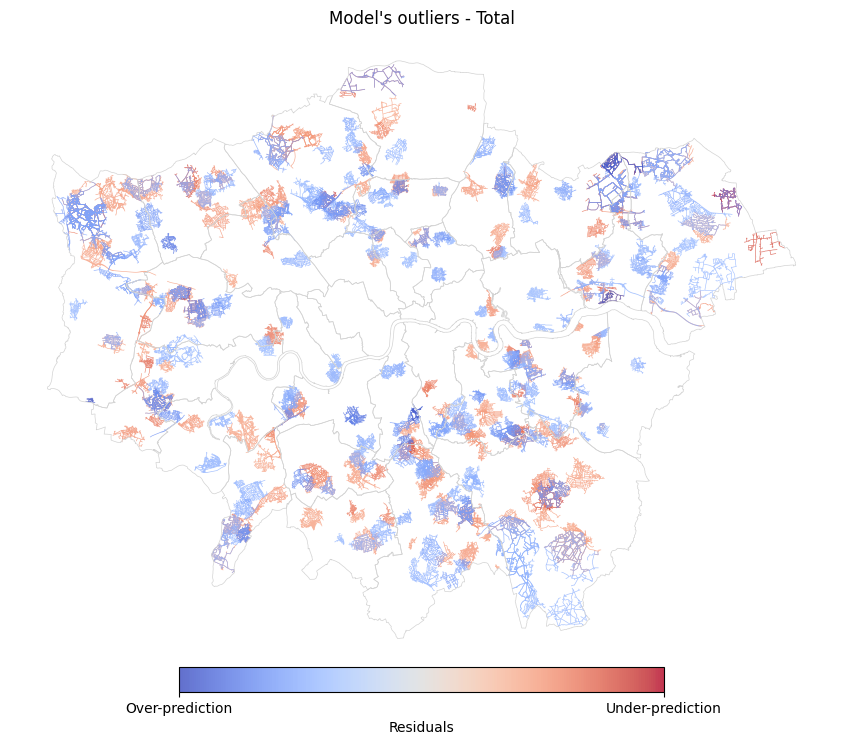

Timeband: Morning
Number of outliers - underpredicting: 188
Number of outliers - overpredicting: 207


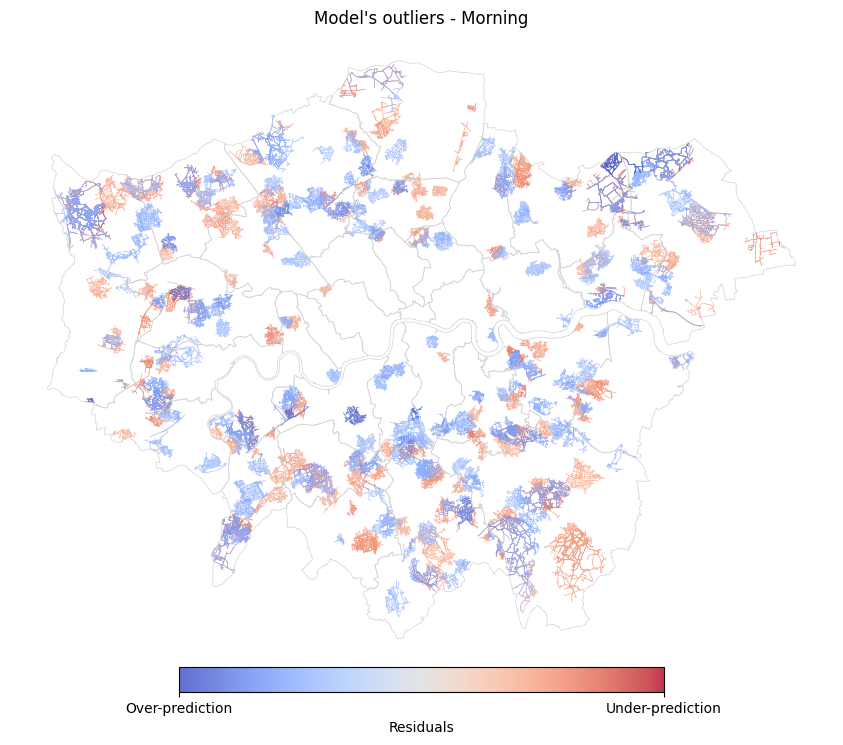

Timeband: Midday
Number of outliers - underpredicting: 178
Number of outliers - overpredicting: 211


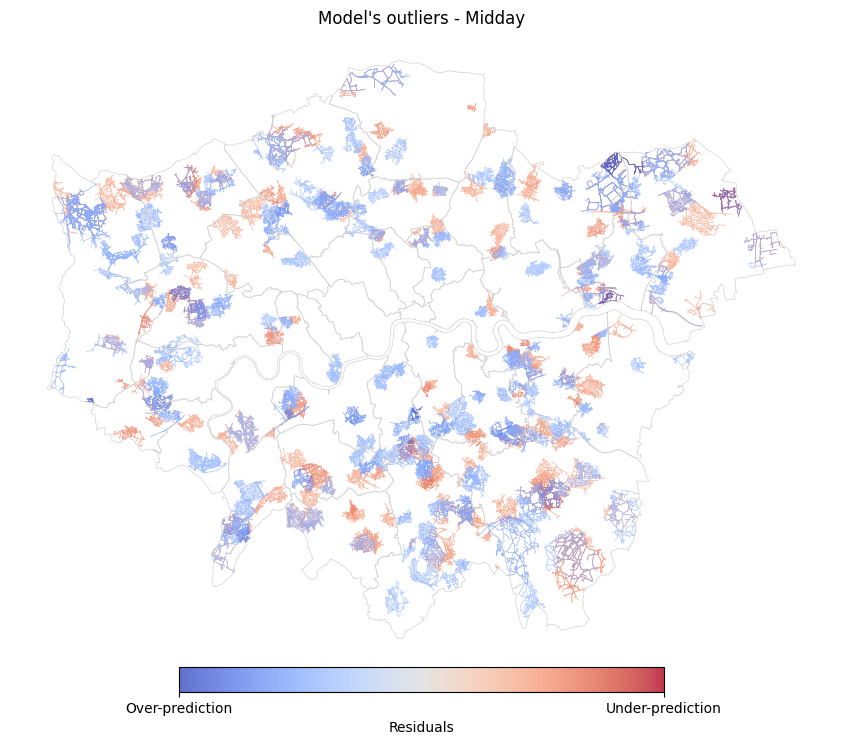

Timeband: Evening
Number of outliers - underpredicting: 170
Number of outliers - overpredicting: 223


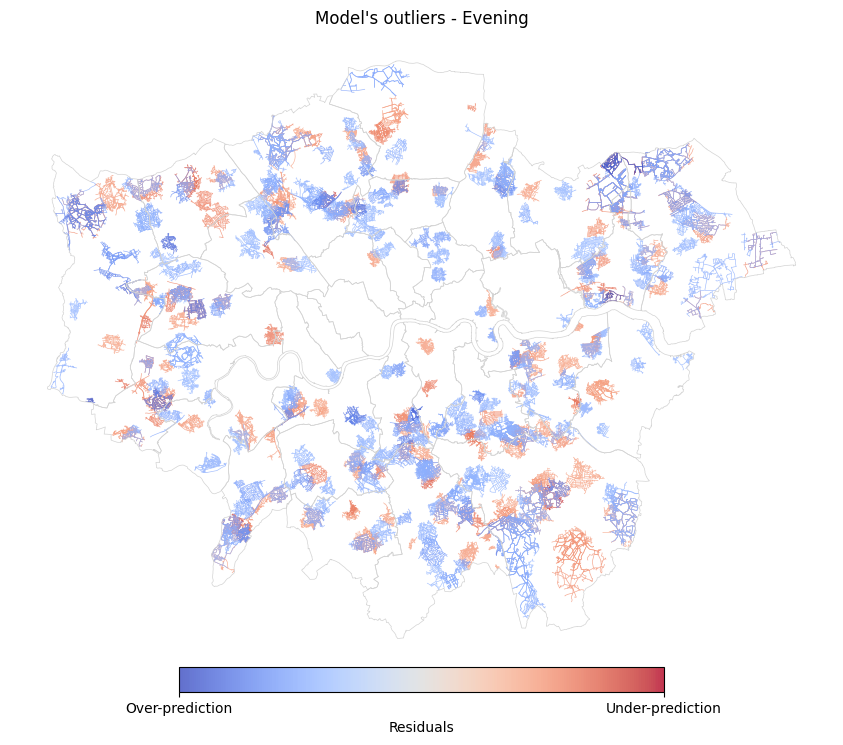

Timeband: Late
Number of outliers - underpredicting: 195
Number of outliers - overpredicting: 216


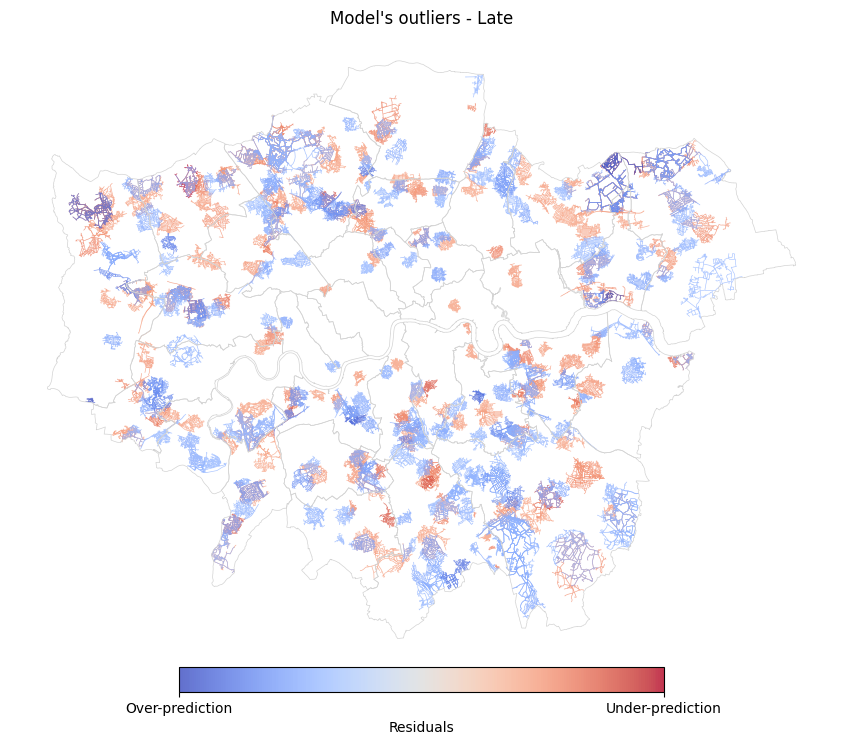

In [284]:
# Get and Plot the outliers for each timeband
for i,target in enumerate(targets):
    
    # Get outliers
    df_outliers = get_outliers_xy(df, model, features, target)
    col_name = 'residuals_'+target

    #Report
    num_outliers_upper = (df_outliers[col_name] > 0).sum()
    num_outliers_lower = (df_outliers[col_name] < 0).sum()

    print(f"Timeband: {target}")
    print(f"Number of outliers - underpredicting: {num_outliers_upper}")
    print(f"Number of outliers - overpredicting: {num_outliers_lower}")

    # Plot
    vmin = -0.07
    vmax = 0.07
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    df_outliers.plot(ax=ax, 
                    column = col_name, 
                    alpha=0.8, legend=False, 
                    cmap='coolwarm',
                    vmin=vmin, vmax=vmax)
                    
    boros.boundary.plot(ax=ax, color='lightgrey', linewidth=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(ax.collections[0], ax=ax, orientation='horizontal', ticks=[-0.07, 0.07],shrink=0.5, pad=0)
    cbar.ax.set_xticklabels(['Over-prediction', 'Under-prediction'])  # horizontal colorbar
    cbar.set_label('Residuals')

    plt.title('Model\'s outliers - '+target)
    plt.axis('off')
    plt.tight_layout()
    # plt.savefig(f'output/outliers/{i} {target}.png')
    plt.show()

In [ ]:
# create a gif of the outliers for all timebands
images = []
for filename in sorted(glob.glob('output/outliers/*.png')):
    if 'Total' not in filename:
        images.append(imageio.imread(filename))

imageio.mimsave('output/outliers/gif/outliers_iqr.gif', images, duration=1000, loop=0)

Explore outliers

In [ ]:
def plot_boro_outlier(boro,target):

    boro_boundary = boros[boros['NAME'] == boro]
    df_boro = df[df.intersects(boro_boundary.unary_union)]

    residual_col = 'residuals_'+target
    outliers_col = 'is_outlier_'+target

    # df_boro_grouped = df_boro.groupby(outliers_col)[features_main].agg(['mean','median'])
    # print(df_boro_grouped)

    # plot outliers and non-outliers in Enfield, color by residuals_target
    fig, ax = plt.subplots(1, 2, figsize=(8, 15), sharex=True, sharey=True)

    vmin = -0.07
    vmax = 0.07

    df_boro[df_boro[outliers_col] == 0].plot(ax=ax[0], 
                                                    column = residual_col, 
                                                    alpha=0.8, vmin=vmin, vmax=vmax,
                                                    cmap='coolwarm')
    ax[0].set_title(f'Non-Outliers - {boro.title()}')

    df_boro[df_boro[outliers_col] == 1].plot(ax=ax[1],
                                                    column = residual_col, 
                                                    alpha=0.8, vmin=vmin, vmax=vmax,   
                                                    cmap='coolwarm')    
    ax[1].set_title(f'Outliers - {boro.title()}')

    # shared legend colorbar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', label='Residuals',shrink=0.5, pad=0,ticks=[-0.07, 0.07])
    cbar.ax.set_xticklabels(['Over-prediction', 'Under-prediction'])  # horizontal

    for a in ax:
        a.axis('off')
        boro_boundary.boundary.plot(ax=a, color='black', linewidth=0.5)
        
    plt.show()

In [ ]:
plot_boro_outlier('Croydon','Total')

In [ ]:
chosen_boro = 'Croydon'

# mean testing to see if the outliers and non-outliers are significantly different
df_boro = df[df.intersects(boros[boros['NAME'] == chosen_boro].unary_union)]

# over_under column based on residuals of Total
df_boro['over_under'] = np.where(df_boro['residuals_Total'] > 0, 'under', 'over')
df_boro['is_outlier_Total_'] = df_boro['is_outlier_Total'].replace({0: 'Non-Outlier', 1: 'Outlier'})
df_boro['is_outlier_Total_'] = np.where((df_boro['is_outlier_Total_'] == 'Outlier') & (df_boro['over_under'] == 'under'), 'Outlier - Under', df_boro['is_outlier_Total_'])
df_boro['is_outlier_Total_'] = np.where((df_boro['is_outlier_Total_'] == 'Outlier') & (df_boro['over_under'] == 'over'), 'Outlier - Over', df_boro['is_outlier_Total_'])

# boxplot for df_boro_grouped
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

df_boro.boxplot(column='lag_Total', by='is_outlier_Total_', ax=ax, showfliers=False)
ax.set_title('lag_Total')
ax.set_xlabel('')
ax.grid(False)

plt.tight_layout()
plt.suptitle('Outliers vs Non-Outliers - '+chosen_boro.title()+'\nTotal', y=1.02)
plt.show()


# # boxplot for df_boro_grouped
# fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# for i,feature in enumerate(features):
#     ax = axes.flatten()[i]
#     df_boro.boxplot(column=feature, by='is_outlier_Total_', ax=ax, showfliers=False)
#     # df_boro_grouped[feature].plot(kind='bar', ax=ax, legend=False)
#     ax.set_title(feature)
#     ax.set_xlabel('')
#     ax.grid(False)
#     if i >= 20:
#         ax.set_xticklabels(['Non-\nOutliers', 'Outliers\nOverpred.', 'Outliers\nUnderpred.'])
#     else:
#         ax.set_xticklabels([])

# plt.tight_layout()
# plt.suptitle('Outliers vs Non-Outliers - '+chosen_boro.title()+'\nTotal', y=1.02)
# plt.show()

In [ ]:
# extract the outliers for each feature and timeband
for feature in features_main:  
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax= ax.flatten()
    for i,target in enumerate(targets[1:]):   

        # Get outliers           
        df_outlier_toPlot = df[df[f'is_outlier_{target}']==1]
        
        q1 = df_outlier_toPlot[feature].quantile(0.25)
        q3 = df_outlier_toPlot[feature].quantile(0.75)

        iqr = q3 - q1
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        
        df_plot = df_outlier_toPlot[(df_outlier_toPlot[feature] > upper_bound)]
        
        col_name = 'residuals_'+target

        # Plot
        vmin = -0.07
        vmax = 0.07
        df_plot.plot(ax=ax[i], 
                    column = col_name, 
                    alpha=1, legend=False, 
                    cmap='RdBu_r',
                    vmin=vmin, vmax=vmax)
        
        ax[i].set_title(f'{target}')
        ax[i].axis('off')
                    
        boros.boundary.plot(ax=ax[i], color='lightgrey', linewidth=0.5)
    
    # Add colorbar
    cbar = fig.colorbar(ax[0].collections[0], ax=ax, orientation='horizontal', ticks=[-0.07, 0.07],shrink=0.3, pad=0.1)
    cbar.ax.set_xticklabels(['Over-prediction\n(Less PT demand than predicted)', 'Under-prediction\n(More PT demand than predicted)'])  # horizontal colorbar
    cbar.set_label('Residuals', loc='center', weight='bold')

    plt.axis('off')
    plt.suptitle(f'Model outliers with high density of\n{feature}',y=0.85, fontsize=15)
    plt.savefig(f'output/outliers/{feature}_alltimebands.jpg')
    plt.show()
    

    ## UNDERPREDICTION: more inflow than predicted based on profile
    ## OVERPREDICTION: less inflow than predicted based on profile

In [ ]:
df.to_csv('data/cleaned/df_ml_new_resid.csv', index=False)

# 4. Extract SHAP explanations (global/local)

Explain a sample for plotting

In [ ]:
%%time
# For each of the models, obtain SHAP Explainer object for test data
shap_list_ = {} # test data

for target in targets_log:  
    
    # select the features and target
    X = df[features + [lags[targets_log.index(target)]]]
    y = df[target]
    
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # fit the model
    model.fit(X, y)

    # Create a SHAP explainer object
    background = shap.sample(X, 1000, random_state=random_seed)
    explainer = shap.Explainer(model, background)

    # Explain the X_test data
    print(f"Explaining {target}...for 1000 rows")
    # Explain a subset of the dataset
    X_explain = pd.DataFrame(X, columns=features + [lags[targets_log.index(target)]])
    X_explain = X_explain.sample(1000, random_state=random_seed,axis=0)

    shap_values1 = explainer(X_explain)
    shap_list_[target]= shap_values1 # add to the dictionary - test data

# export shap_list
with open('data/modeltraining/shap_list_test.pkl', 'wb') as file:
    pickle.dump(shap_list_, file)

Explaining log_Total...for 1000 rows


100%|===================| 999/1000 [36:16<00:02]        

Explaining log_Morning...for 1000 rows


100%|===================| 999/1000 [28:40<00:01]        

Explaining log_Midday...for 1000 rows


100%|===================| 999/1000 [35:14<00:02]        

Explaining log_Evening...for 1000 rows


100%|===================| 999/1000 [41:52<00:02]        

Explaining log_Late...for 1000 rows


100%|===================| 999/1000 [43:46<00:02]        

CPU times: total: 2h 7min 57s
Wall time: 3h 28min 20s


Explain the whole thing

In [ ]:
%%time
# For each of the models, obtain S HAP Explainer object for test data
shap_list = {} # full data

for target in targets_log:    
    
    # select the features and target
    X = df[features + [lags[targets_log.index(target)]]]
    y = df[target]
    
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # fit the model
    model.fit(X, y)

    # Create a SHAP explainer object
    background = shap.sample(X, 1000, random_state=random_seed)
    explainer = shap.Explainer(model, background)
    
    # Explain the whole data
    print(f"Explaining {target}...full dataset")
    X_explain = pd.DataFrame(X, columns=features + [lags[targets_log.index(target)]])
    # X_explain = X_explain.sample(1000, random_state=random_seed,axis=0)

    shap_values2 = explainer(X_explain)
    shap_list[target]= shap_values2 # add to the dictionary - full data


with open('data/modeltraining/shap_list.pkl', 'wb') as file:
    pickle.dump(shap_list, file)

Explaining log_Total...full dataset


100%|===================| 16889/16890 [500:29<00:01]         

Explaining log_Morning...full dataset


100%|===================| 16889/16890 [518:19<00:01]         

Explaining log_Midday...full dataset


100%|===================| 16889/16890 [564:08<00:02]         

Explaining log_Evening...full dataset


100%|===================| 16889/16890 [500:58<00:01]         

Explaining log_Late...full dataset


100%|===================| 16889/16890 [461:05<00:01]         

CPU times: total: 13h 14min 25s
Wall time: 1d 18h 42min 24s


# Add-on: What if without lags

In [ ]:
# Set up spatial cross-validation folds

df_point = df.copy()
df_point['geometry'] = [Point(x,y) for x,y in zip(df_point['x_coords'],df_point['y_coords'])]
df_point = gpd.GeoDataFrame(df_point, geometry='geometry', crs='EPSG:27700')

# spatial kfold
df_clusters = spatial_kfold_clusters (gdf=df_point, name = 'id_code', nfolds = 5, algorithm='kmeans',
                                        random_state = random_seed, verbose = False) 

groups = df_clusters["folds"] # Cross-validation grouping setup
group_cvs =  LeaveOneGroupOut() # for spatial cross-validation when training the data
# group_kfold = GroupKFold(n_splits=10) # for spatial cross-validation when testing the data
groups.unique()

In [ ]:
##without tuning, use the best models from the previous notebook

# Load tuned model log_Total from last notebook to initialize
with open('data/modeltraining/best_xgb_1407.pkl', 'rb') as file:
    model = pickle.load(file)
# load base models dictionary

# dictionary with 4 columns for Timeband, MAE, MSE, R2
results_xgb = pd.DataFrame()

# iterate for each tuned model above
for target in targets_log: # use log_ for target
    target_sel = target
    features_sel = features

    # select the features and target
    X = df[features_sel]  
    y = df[target_sel]

    # list to store the scores for each fold so that we can calculate the mean later
    mae_scores = []
    mse_scores = []
    r2_scores = []

    # iterate for each log_ target
    for train_index, test_index in group_cvs.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Fit the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate the scores, add to the list
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))  #MSE
        r2_scores.append(r2_score(y_test, y_pred))

    # Calculate the mean scores
    mean_mae = np.mean(mae_scores)
    mean_mse = np.mean(mse_scores)
    mean_r2 = np.mean(r2_scores)
    print(f"\n{target}:")
    print(f"Mean MAE: {mean_mae}")
    print(f"Mean MSE: {mean_mse}")
    print(f"Mean R^2: {mean_r2}")

    # add the mean scores to the dataframe
    ddf = pd.DataFrame({'Timeband': [target], 'MAE': [mean_mae], 'MSE': [mean_mse], 'R2': [mean_r2]})
    results_xgb = pd.concat([results_xgb, ddf], ignore_index=True,axis=0)

results_xgb

In [ ]:
%%time
# For each of the models, obtain SHAP Explainer object for test data
shap_list_ = {} # test data

for target in targets_log:  
    
    # select the features and target
    X = df[features]
    y = df[target]
    
    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # fit the model
    model.fit(X, y)

    # Create a SHAP explainer object
    background = shap.sample(X, 1000, random_state=random_seed)
    explainer = shap.Explainer(model, background)

    # Explain the X_test data
    print(f"Explaining {target}...for 1000 rows")
    # Explain a subset of the dataset
    X_explain = pd.DataFrame(X, columns=features)
    X_explain = X_explain.sample(1000, random_state=random_seed,axis=0)

    shap_values1 = explainer(X_explain)
    shap_list_[target]= shap_values1 # add to the dictionary - test data
    

In [ ]:
for target in targets_log[1:]:
    shap_values = shap_list_[target]
    
    shap.plots.beeswarm(shap_values, max_display=20,show=False)

    plt.title('SHAP feature importance \n'+target)
    plt.tight_layout()
    # plt.savefig(f'output/shap/new_{target}.png')
    plt.show()

In [ ]:
for target in targets_log:
    shap_values = shap_list_[target]
    
    target_sel = target
    features_sel = features

    X = df[features_sel]
    y = df[target_sel]

    clustering = shap.utils.hclust(X,y,metric='xgboost_distances_r2')
    shap.plots.bar(shap_values, max_display=20, clustering=clustering, clustering_cutoff=0.4,show=False)
    plt.title('SHAP feature importance with correlated feature clusters \n'+target)
    plt.tight_layout()
    # plt.savefig(f'output/shap/new_barclus_{target}.png')
    plt.show()

In [ ]:
# partial depence plot for feature and prediction
def pd_plot(feature, target):
    X_ = df[features].sample(1000, random_state=random_seed,axis=0)
    y_ = df[target].sample(1000, random_state=random_seed,axis=0)

    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    
    model.fit(X_, y_)
    y_pred = model.predict(X_)

    # plot X_ vs y_pred, color equals shap value of feature
    plt.figure(figsize=(10,6))
    plt.scatter(X_[:,features.index(feature)], y_pred, alpha=0.5, c=shap_list_[target].values[:,features.index(feature)])

    plt.xlabel(feature)
    plt.ylabel('Predicted '+target)

    cbar = plt.colorbar()
    cbar.set_label('SHAP value of '+feature)
    plt.title('Partial dependence plot of '+feature+' on '+target)
    plt.tight_layout()
    plt.show()

for target in targets_log[1:]:
    pd_plot('poi_leisure_outdoor',target)